In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import h5py
import dask.dataframe as dd
from HDF5Dataset import HDF5Dataset
import joblib
import numpy as np
import json
from dask_ml.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from architecture.RNN import RNN
import gc
from scipy.io import arff
import pandas as pd

In sequential models, current hidden state is a function of the current input and previous hidden state:


### h(t) = f(h(t-1), x(t); W)

W are the parameters of function (in our case NN)
 

For RNN:

a(t) = W * h(t-1) + U * x(t) + b1
h(t) = tanh(a(t))
o(t) = V * h(t) + b2

In [2]:
# Initialise device

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Primary device set to GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Primary device set to CPU.")

CUDA is not available. Primary device set to CPU.


In [3]:

def dask_sequence_generator(input_df, labels, window_size, stride=1, batch_size=20000):
    # Convert Dask DataFrame to Dask Array for easier slicing
    df_array = input_df.to_dask_array(lengths=True)
    label_array = labels.to_dask_array(lengths=True)

    # Compute total length using the .shape attribute of the Dask Array
    total_length = df_array.shape[0]
    
    # Initialize start index and lists for sequences and outputs
    start = 0
    sequences = []
    outputs = []
    
    while start < total_length - window_size:
        end = start + window_size
        # Append the slice of the array (all columns in the window)
        sequences.append(df_array[start:end].compute())  # Compute necessary for yielding numpy arrays
        
        # Outputs could be the next row or specific columns depending on the task
        outputs.append(label_array[end-1].compute())  # Compute the next point
        
        start += stride
        
        # Yield batch when enough sequences have been collected
        if len(sequences) >= batch_size:
            yield np.array(sequences), np.array(outputs)
            sequences = []
            outputs = []
    
    # Yield any remaining sequences after the loop
    if len(sequences) > 0:
        yield np.array(sequences), np.array(outputs)



In [4]:
def write_to_hdf5(input_df, label_column, window_size, stride_size, batch_size, storage_path, dataset_name, 
                  label_name = 'label'):
    sequence_data_size = int(np.floor((len(input_df) - window_size) / stride_size ))
    print(input_df.columns)
    x_df = input_df.drop(columns = [label_column]).persist()
    y_df = input_df[[label_column]]
    num_features = x_df.shape[1]  # Number of features (columns) in the DataFrame
    print(num_features)
    gen = dask_sequence_generator(x_df, y_df, window_size, stride_size, batch_size)
    
    with h5py.File(storage_path, 'w') as f:
        # Create a dataset with pre-allocated memory for sequences and features
        dset = f.create_dataset(dataset_name, (sequence_data_size, window_size, num_features), dtype='float32')
        y_set = f.create_dataset(label_name, sequence_data_size)
        count = 0
        
        for batch in gen:
            features = batch[0]
            y = batch[1]
            num_data = features.shape[0]
            dset[count:count + num_data] = features
            y_set[count: count + num_data] = np.squeeze(y)
            count += num_data

In [5]:
def load_arff_to_dask(file_path):
    data, meta = arff.loadarff(file_path)
    # Convert to Pandas DataFrame
    df = pd.DataFrame(data)
    df = dd.from_pandas(df, npartitions=1)
    return df

df = load_arff_to_dask('data/EEG Eye State.arff')


# # Convert the column to numeric float16
df['eyeDetection'] = dd.to_numeric(df['eyeDetection'], errors='coerce')
df['eyeDetection'] = df['eyeDetection'].astype('int32')
# 
# # Use map_partitions to apply the pandas interpolate method to each partition
# df['Daily minimum temperatures'] = df['Daily minimum temperatures'].map_partitions(
#     lambda s: s.interpolate(method='linear'), meta=('x', 'float16'))
shape = df.shape
print(shape[0].compute(), shape[1])
display(df.head())

14980 15


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [6]:
df.dtypes

AF3             float64
F7              float64
F3              float64
FC5             float64
T7              float64
P7              float64
O1              float64
O2              float64
P8              float64
T8              float64
FC6             float64
F4              float64
F8              float64
AF4             float64
eyeDetection      int32
dtype: object

In [7]:
# Apply scaler and also save the columns and their order

column_order = list(df.columns)
print(column_order)
with open('meta/model_d2_column_order.json', 'w') as f:
    json.dump(column_order, f)
    
# Create and fit the scaler
scaler = RobustScaler()
scaler.fit(df)

scaled_df = scaler.transform(df)
scaled_df = scaled_df.persist()
scaled_df['eyeDetection'] = scaled_df['eyeDetection'].astype('long')
display(scaled_df.head())

['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'eyeDetection']


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,1.114770,0.111111,1.300341,1.149378,0.733593,-2.137097,1.039782,1.421971,1.222102,0.486301,0.512369,0.184197,1.230596,1.266818,0
1,0.967391,-0.031569,1.525597,1.170539,0.200130,-2.102151,1.060062,1.316222,0.611051,-0.134879,0.341579,0.131862,1.115111,0.949951,0
2,1.065537,0.031879,1.600195,1.489627,-0.133203,-2.309140,1.039782,0.869097,0.444204,-0.378293,0.293054,0.263212,0.961380,1.116672,0
3,1.098465,0.190344,1.650414,1.468465,0.300195,-2.378360,1.060062,0.895277,0.972373,0.324025,0.488107,0.552591,1.095988,1.350016,0
4,1.016304,0.190344,1.450512,1.276763,0.566602,-2.102151,1.000000,0.737166,0.611051,0.783456,0.585633,0.579271,1.115111,1.416640,0


In [8]:
# Find diff between max and min
print(df.min().compute())
print((scaled_df.max() - scaled_df.min()).compute())
print(scaled_df.mean().compute())
print(scaled_df.std().compute())

AF3             1030.7700
F7              2830.7700
F3              1040.0000
FC5             2453.3300
T7              2089.7400
P7              2768.2100
O1              2086.1500
O2              4567.1800
P8              1357.9500
T8              1816.4100
FC6             3273.3300
F4              2257.9500
F8                86.6667
AF4             1366.1500
eyeDetection       0.0000
dtype: float64
AF3              9852.948529
F7                153.941504
F3                284.764018
FC5             26560.608714
T7                284.900585
P7              24179.824597
O1              22039.502730
O2                138.445585
P8              14316.524919
T8                255.951001
FC6               168.874881
F4                243.438173
F8               5707.586550
AF4             23221.672083
eyeDetection        1.000000
dtype: float64
AF3             0.881003
F7              0.127753
F3              0.071303
FC5             1.843831
T7              0.180057
P7              1.75

In [9]:
window_size = 120
stride_size = 1
batch_size = 32
write_to_hdf5(scaled_df, 'eyeDetection', window_size,
              stride_size, batch_size, 'meta/sequence_d2.h5', 'sequences')

partitioned_df = scaled_df.repartition(npartitions = 5)
write_to_hdf5(partitioned_df, 'eyeDetection', window_size,
              stride_size, batch_size, 'meta/partitioned_sequence_d2.h5', 'sequences')



Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4', 'eyeDetection'],
      dtype='object')
14
Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4', 'eyeDetection'],
      dtype='object')
14


In [10]:
## Check if partitioned dataframe has any affect on file generated

file_path = 'meta/sequence_d2.h5'
hdf5_file = h5py.File(file_path, 'r')
data = hdf5_file['sequences']

file_path = 'meta/partitioned_sequence_d2.h5'
p_hdf5_file = h5py.File(file_path, 'r')
p_data = p_hdf5_file['sequences']

print(data.shape)
print(p_data.shape)

# print(p_data[0])
# print(data[0])

assert len(data) == len(p_data)

hdf5_file.close()
p_hdf5_file.close()

(14860, 120, 14)
(14860, 120, 14)


In [11]:
# Open the original HDF5 file
file_path = 'meta/partitioned_sequence_d2.h5'
hdf5_file = h5py.File(file_path, 'r')  # Open in read-only mode
data = hdf5_file['sequences']
labels = hdf5_file['label']

# Create new HDF5 files for training and testing data
train_file = h5py.File('meta/train_data.h5', 'w')
test_file = h5py.File('meta/test_data.h5', 'w')

# Create datasets for data in the new files
train_dataset = train_file.create_dataset('data', (0,) + data.shape[1:], maxshape=(None,) + data.shape[1:], dtype=data.dtype)
test_dataset = test_file.create_dataset('data', (0,) + data.shape[1:], maxshape=(None,) + data.shape[1:], dtype=data.dtype)

# Create datasets for labels in the new files
train_labels = train_file.create_dataset('label', (0,) + labels.shape[1:], maxshape=(None,) + labels.shape[1:], dtype=labels.dtype)
test_labels = test_file.create_dataset('label', (0,) + labels.shape[1:], maxshape=(None,) + labels.shape[1:], dtype=labels.dtype)


In [12]:
train_segment_size = 1600
test_segment_size = 400
total_samples = data.shape[0]

i = 0
while i < total_samples:
    end_train = min(i + train_segment_size, total_samples)
    if end_train > i:  # Check if there is data to process
        train_dataset.resize(train_dataset.shape[0] + (end_train - i), axis=0)
        train_dataset[-(end_train - i):] = data[i:end_train]
        train_labels.resize(train_labels.shape[0] + (end_train - i), axis=0)
        train_labels[-(end_train - i):] = labels[i:end_train]

    i = end_train
    end_test = min(i + test_segment_size, total_samples)
    if end_test > i:  # Check if there is data to process
        test_dataset.resize(test_dataset.shape[0] + (end_test - i), axis=0)
        test_dataset[-(end_test - i):] = data[i:end_test]
        test_labels.resize(test_labels.shape[0] + (end_test - i), axis=0)
        test_labels[-(end_test - i):] = labels[i:end_test]

    i = end_test

train_file.close()
test_file.close()
hdf5_file.close()

In [62]:
# Assume the paths to your HDF5 files
train_file_path = 'meta/train_data.h5'
test_file_path = 'meta/test_data.h5'

# Create dataset instances
train_dataset = HDF5Dataset(train_file_path, 'data', 'label')
test_dataset = HDF5Dataset(test_file_path, 'data', 'label')




In [63]:
# train_dataset.__getitem__(2)[0].shape

In [64]:
# Save scaler to disk
joblib.dump(scaler, 'meta/model_d2_robust_scaler.joblib')

['meta/model_d2_robust_scaler.joblib']

In [65]:
class MultivariateTSModel(nn.Module):
    def __init__(self):
        super(MultivariateTSModel, self).__init__()
        self.rnn_in = RNN(14, 28, 10, 1)
        # self.rnn_out = RNN(10, 25, 5, 1)
        self.fc1 = nn.Linear(10, 30)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(30, 1)
    
    def forward(self, x):
        l1 = self.rnn_in(x)
        # l1 = self.rnn_out(l1)
        l1 = torch.tanh(l1[:, -1, :])
        out = self.fc1(l1)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [66]:
class MultivariateTSModelTorch(nn.Module):
    def __init__(self):
        super(MultivariateTSModelTorch, self).__init__()
        # Initialize the RNN to process input with 14 features and output with 28 hidden features, stacked 10 layers deep
        self.rnn_in = nn.RNN(14, 28, num_layers=2, batch_first=True)
        # Linear layer to expand the last hidden state
        self.fc1 = nn.Linear(28, 30)
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        # Final output layer
        self.fc2 = nn.Linear(30, 1)
    
    def forward(self, x):
        # Process input through RNN
        # rnn_in outputs both the final hidden states for each layer and the last layer's outputs for each timestep
        # We only need the last timestep's output of the last layer
        out, _ = self.rnn_in(x)
        # Selecting the last timestep's output
        out = out[:, -1, :]
        # Applying non-linear transformations
        out = torch.tanh(out)
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


In [83]:
model = MultivariateTSModelTorch()

classifying_loss = nn.BCEWithLogitsLoss()
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [85]:
# Create DataLoader instances
train_loader_arr = []
train_loader = DataLoader(train_dataset, batch_size = 32, num_workers = 4, shuffle = True)
ns_train_loader = DataLoader(train_dataset, batch_size = 32, num_workers = 4, shuffle = False)

train_loader_arr.append(train_loader)
train_loader_arr.append(ns_train_loader)


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_epochs = 15

for epoch in range(num_epochs):
    loss_arr = []
    model.train()
    for data, labels in train_loader_arr[0]:
        adam_optimizer.zero_grad()
        res = model.forward(data)
        # out = res[:, -1, :]
        out = res
        loss = classifying_loss(out, labels.view(-1, 1))
        
        loss_arr.append(loss.item())
        loss.backward()
        adam_optimizer.step()
        
    test_loss_arr = []
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            res = model.forward(data)
            out = res
            loss = classifying_loss(out, labels.view(-1, 1))
            test_loss_arr.append(loss.item())
    
    print("Epoch - ", epoch, " loss: ",np.mean(loss_arr), " test loss: ",np.mean(test_loss_arr))
    

Epoch -  0  loss:  0.5307652136590999  test loss:  0.5201942972997402
Epoch -  1  loss:  0.4715412019758634  test loss:  0.42792331847421666
Epoch -  2  loss:  0.39729398609914757  test loss:  0.4393877821003503
Epoch -  3  loss:  0.38501254584738065  test loss:  0.39040378251291336
Epoch -  4  loss:  0.42792510662699085  test loss:  0.3921024292073351
Epoch -  5  loss:  0.4531240864058952  test loss:  0.441705677103489
Epoch -  6  loss:  0.3529631560557213  test loss:  0.30552078432779994
Epoch -  7  loss:  0.32867778682979026  test loss:  0.30622857479140797
Epoch -  8  loss:  0.277371377846435  test loss:  0.26850014394446414
Epoch -  9  loss:  0.41441986885873117  test loss:  0.4219108981258692
Epoch -  10  loss:  0.4042853642263959  test loss:  0.3603358778983672
Epoch -  11  loss:  0.37690909583841703  test loss:  0.3930651736445725
Epoch -  12  loss:  0.3502407911942654  test loss:  0.34470035800551796
Epoch -  13  loss:  0.3303136701622271  test loss:  0.3326299561663194
Epoch 

In [61]:
# del test_loader
# del train_loader
# del ns_train_loader
# del train_dataset
# del test_dataset
# 
# gc.collect()

1904

In [18]:
# !jupyter nbconvert --to script RNN-from-scratch.ipynb
# 
# h5py.__version__
labels.dtype

torch.float32

In [86]:
loss_sum = 0
# model_basic = RNN(1, 3, 1, 2)
actual = []
pred_proba = []
pred = []
acc = []
model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        res = model.forward(data)
        # out = res[:, -1, :]
        # out = torch.sigmoid(res)
        out = res
        threshold = 0
        pred_proba.extend(out.view(-1).numpy())
        pred.extend((out > threshold).long().view(-1).numpy())
        actual.extend(labels.view(-1, 1).long().view(-1).numpy())
        # print(out.shape, labels.view(-1).shape)
        # break
        acc.extend(((out > threshold).long() == labels.view(-1, 1).long()).view(-1).numpy())
        # print(scaler.inverse_transform(out), scaler.inverse_transform(labels))
        # actual.extend(scaler.inverse_transform(labels).detach().numpy())
        # pred.extend(scaler.inverse_transform(out).detach().numpy())
        # loss = classifying_loss(out, labels.view(-1, 1))
        # loss_sum += loss.item()
    
# print(acc)

In [87]:
# pred_proba

In [88]:
pred.count(0)

858

In [89]:
acc.count(True)/(acc.count(True)+acc.count(False))

0.8662162162162163

In [56]:
(out.long() == labels.view(-1, 1).long()).view(-1).numpy()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

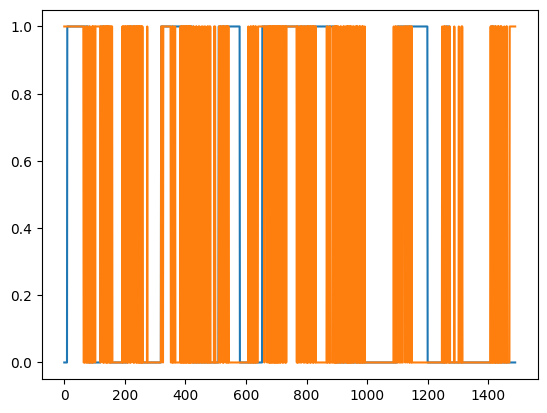

In [57]:
plt.plot(actual)
plt.plot(pred)
plt.show()

In [23]:
err_arr = []
for pair in zip(actual, pred):
    err_arr.append(abs((pair[0] - pair[1])[0]))
print(100*np.mean(err_arr)/np.mean(actual), " % error on average")

24.14046288595072  % error on average


In [34]:
test_dataset.__getitem__(0)

(array([[ 0.37691817, -0.09532653,  0.72549975, ...,  0.6054387 ,
          0.9422572 ,  0.36659083],
        [ 0.22953965, -0.14268029,  0.5753291 , ...,  0.36839405,
          0.74990624,  0.46668833],
        [ 0.4590793 ,  0.1268957 ,  0.3003413 , ...,  0.2632119 ,
          0.807649  ,  0.3834904 ],
        ...,
        [ 2.1476982 , -2.1903436 , -0.5997075 , ...,  2.6839404 ,
          6.248969  ,  3.6665583 ],
        [ 1.7215474 , -2.6663573 , -0.87469524, ...,  2.3945613 ,
          5.730034  ,  3.4332142 ],
        [ 1.7049233 , -2.5871248 , -0.625061  , ...,  2.81529   ,
          5.864642  ,  3.8332791 ]], dtype=float32),
 1.0)

In [35]:
train_dataset.__getitem__(0)

(array([[ 1.1147698 ,  0.11111111,  1.3003412 , ...,  0.18419702,
          1.2305962 ,  1.2668183 ],
        [ 0.9673913 , -0.03156918,  1.5255972 , ...,  0.13186249,
          1.1151106 ,  0.94995123],
        [ 1.0655371 ,  0.03187868,  1.600195  , ...,  0.2632119 ,
          0.9613798 ,  1.116672  ],
        ...,
        [ 0.22953965, -0.20643763,  0.        , ...,  0.36839405,
          0.44206974,  0.03347416],
        [ 0.18030691, -0.01578459, -0.02486592, ...,  0.6316059 ,
          0.8267717 ,  0.23334417],
        [ 0.3280051 ,  0.1268957 ,  0.05021941, ...,  0.6054387 ,
          0.9422572 ,  0.46668833]], dtype=float32),
 0.0)